In [61]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft, ifft
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import chi2
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# Wavelet code

In [109]:
def wavelet(Y, dt: int, dj=0.025):
    """
    Perform a Continuous Wavelet Transform (CWT) on a time series using the Morlet wavelet, calculating its power spectrum.

    :param Y: NumPy array of the original time series data to be analyzed.
    :param dt: Integer specifying the temporal resolution of the timeseries. For monthly dt=12, for daily dt=365, for yearly dt=1.
    :param dj: Float, optional, specifying the spacing between discrete scales for the wavelet transform. Defaults to 0.025.
    :return: A dictionary containing the wavelet transform ('wave'), associated periods ('period'), scales used ('scale'), wavelet power spectrum ('power'), cone of influence ('coi'), and average power across all times for each scale ('avg_power').
    """
    
    DT = 1/dt  # Timestep for monthly data
    pad = 1  # Pad data
    param = 6  # Wavenumber for Morlet
    s0 = 2 * DT  # Standard smallest resolvable scale
    n1 = len(Y)  # Total observations
    J1 = int(np.floor((np.log2(n1 * DT / s0)) / dj)) # Equation 10

    # Center and optionally pad the time series to nearest base 2 power
    x = (Y - np.mean(Y))
    if pad == 1:
        base2 = int(np.trunc(np.log(n1) / np.log(2) + 0.4999))
        x = np.concatenate((x, np.zeros(2 ** (base2 + 1) - n1)))

    n = len(x)  # Length with pad, nearest base 2 power

    # Construct wavenumber array
    k = np.arange(1, int(n / 2) + 1)
    k = k * ((2 * np.pi) / (n * DT))
    k = np.concatenate(([0], k, -np.flip(k[:int((n - 1) / 2)])))

    # Compute FFT of the (padded) time series
    f = fft(x)

    # Construct scale array and initialize wave array
    scale = s0 * 2 ** (np.arange(0, J1 + 1) * dj) # Equation 9
    wave = np.zeros((J1 + 1, n), dtype=complex) 

    
    for a1 in range(J1 + 1):
        scl = scale[a1]
        daughter = np.zeros(n, dtype=complex)
        kpos = k > 0
        expnt = -(scl * k[kpos] - param) ** 2 / 2
        norm = np.sqrt(scl * k[1]) * (np.pi ** (-0.25)) * np.sqrt(n)
        daughter[kpos] = norm * np.exp(expnt)
        wave[a1, :] = ifft(f * daughter) / n

    fourier_factor = (4 * np.pi) / (param + np.sqrt(2 + param ** 2))
    period = fourier_factor * scale

    # Calculate coi
    lengths = np.concatenate((np.arange(1, np.floor((n1 + 1) / 2) + 1), np.arange(1, np.floor(n1 / 2) + 1)[::-1]))
    coi = fourier_factor / np.sqrt(2) * lengths * DT

    wave = wave[:, :n1]  # Remove padding
    power = (np.abs(wave) ** 2)/np.var(wave) # Calculate normalized power spectrum
    avg_power = np.mean(power, axis=1)

    result = {'wave': wave, 'period': period, 'scale': scale, 'power': power, 'coi': coi, 'avg_power': avg_power, 'dt': DT}
    return result

In [63]:
def CI(wlt, dat, conf, noise_type):
    """
    Calculate the confidence interval for a wavelet power spectrum. Based off of Torrence and Compo 1998.
    
    Parameters:
    - conf: Confidence level as a decimal (0-1).
    - dat: Time series data.
    - noise_type: 'r' for red noise, 'w' for white noise.
    
    Returns:
    - A dictionary with the significant levels ('sig') as the key.
    """
    na = len(dat)
    
    if noise_type == "r":
        model = sm.tsa.ARIMA(dat, order=(1, 0, 0) , trend='n').fit() # prevent intercept term #dat/10^10
        alpha = model.params[0] # Equation 15, extract lag-1 autocorr
        print(f'Red Noise AR1 Coefficient: {alpha}')
    else:
        alpha = 0 # For white noise, default 0
    
    ps = wlt['period']
    LP = len(ps)
    freq = 1 / ps
    
    CI = np.zeros(LP)  # Initialize confidence interval empty array
    
    for i in range(LP):
        P = (1 - (alpha**2)) / (1 + (alpha**2) - (2 * alpha * np.cos(2 * np.pi * freq[i])))  # Equation 16
        df = 2 * np.sqrt(1 + ((na / (2.32 * ps[i]))**2))  # Equation 23, 28, determine dof
        CI[i] = P * (chi2.ppf(conf, df) / df) # Equation 18, 26

    dict = wlt.copy()

    dict['sig'] = CI

    return dict

In [64]:
def CI_wrap(wavelet_result: dict, series_data: np.ndarray, time: np.ndarray = None, conf: float = 0.95) -> dict:
    """
    Compute red and white noise significance levels and return a formatted dictionary
    for plotting with wavelet_plot, including a validated 'Time' key.

    Parameters:
    - wavelet_result: Output dictionary from the `wavelet()` function.
    - series_data: Original time series used to compute the wavelet transform.
    - time: Optional time array. If None or invalid, uses np.arange(len(series_data)).
    - conf: Confidence level (default 0.95).

    Returns:
    - Dictionary with keys: 'Power', 'Period', 'COI', 'Avg_Power', 
      'R_noise', 'W_noise', 'Time'.
    """
    # Validate time
    if time is None or not isinstance(time, (np.ndarray, list, pd.Index)) or np.ndim(time) != 1:
        time = np.arange(len(series_data))

    # Compute red and white noise significance levels
    red = CI(wavelet_result, series_data, conf=conf, noise_type='r')
    white = CI(wavelet_result, series_data, conf=conf, noise_type='w')

    # Construct output dictionary
    output = {
        'Power': wavelet_result['power'],
        'Period': wavelet_result['period'],
        'COI': wavelet_result['coi'],
        'Avg_Power': wavelet_result['avg_power'],
        'R_noise': red['sig'],
        'W_noise': white['sig'],
        'Time': np.array(time)
    }

    return output


In [65]:
def wavelet_plot(plt_dataset, siglvl, name = '', resolution = int, sigtest = 'default'):
    """
    Plot the wavelet power spectrum and the global wavelet spectrum of a time series. This function creates a comprehensive visualization of the wavelet analysis results, facilitating the examination of periodicities in the data and their significance against specified noise models.

    :param plt_dataset: A dictionary containing 'Power', 'Period', 'COI', 'Avg_Power', 'R_noise', and 'W_noise' keys representing the wavelet power spectrum data, periods, cone of influence, average power, and significance levels against red and white noise respectively.
    :param siglvl: A float specifying the significance level for the noise tests (e.g., 0.05 for 95% significance).
    :param name: A string that will be the plot title.
    :param resolution: Number of bins for contourf plot.
    :param sigtest: String, optional, indicating the type of significance test to apply. 'red' for red noise, 'white' for white noise, and 'default' for both. Defaults to 'default'.
    :return: None. The function generates and displays two plots: 1) The wavelet power spectrum, showing power as a function of time and period with areas under the cone of influence shaded. 2) The global wavelet power spectrum, comparing average power over time against significance levels derived from noise models.
    """
    
    fig = plt.figure(figsize=(16, 6))  # Adjusted figure size for horizontal layout

    # Adjust GridSpec for colorbar placement to the left of the first plot with extra space
    gs = gridspec.GridSpec(1, 4, width_ratios=[0.1, 2, 1, 0.1], wspace=0.1)
    
    # Define the start and end colors for your palette
    start_color = '#FFFFFF' #white
    midpoint_color = '#6699CC' #lightish blue
    end_color = '#004488' #darker blue
    
    # Create the custom diverging palette
    custom_palette = sns.blend_palette([start_color, midpoint_color, end_color], as_cmap=True)

    # Wavelet power spectrum subplot
    ax_cwt = fig.add_subplot(gs[1])
    max_power = np.max(plt_dataset['Power'])
    levels = np.linspace(0, max_power, resolution)
    
    # Use custom palette for the contourf plot
    time = plt_dataset['Time']
    cs = ax_cwt.contourf(time, np.log2(plt_dataset['Period']), plt_dataset['Power'], 
                         levels=levels, cmap=custom_palette)
    
    ax_cwt.plot(np.arange(time[0], time[0]+len(plt_dataset['COI']), 1), np.log2(plt_dataset['COI']), 'k')
    ax_cwt.fill_between(np.arange(time[0], time[0]+len(plt_dataset['COI']), 1), np.log2(plt_dataset['COI']), np.log2(plt_dataset['Period'][-1]), color='gray', alpha=0.5)
    ax_cwt.set_title(f'Local Wavelet Power Spectrum', fontsize=15)
    ax_cwt.set_ylabel('Period (Years)', fontsize=14)
    ax_cwt.set_xlabel('Time (Year)', fontsize=14)
    ax_cwt.tick_params(axis='both', which='major', labelsize=13)
    ax_cwt.set_ylim(np.log2(64), np.log2(2.1))  # Restricting y-axis limits to 2 to 64 years
    ax_cwt.set_yticks(np.log2([4, 8, 16, 32, 64]))
    ax_cwt.set_yticklabels([4, 8, 16, 32, 64])
    
    # Create colorbar for the first subplot
    cbar = plt.colorbar(cs, ax=ax_cwt, orientation='vertical')
    cbar.ax.tick_params(labelsize=13)  # Adjust colorbar tick label size
    # Set the format of the colorbar labels to one decimal place
    cbar.formatter = FormatStrFormatter('%0.1f')
    cbar.update_ticks()
    
    # Global wavelet spectrum subplot
    ax_global = fig.add_subplot(gs[2])
    ax_global.plot(plt_dataset['Avg_Power'], plt_dataset['Period'], label='Power', linestyle='-')
    if sigtest == 'red':
        ax_global.plot(plt_dataset['R_noise'], plt_dataset['Period'], color='red', label=f'Red Noise {int(siglvl*100)}%', linestyle='--')
    elif sigtest == 'white':
        ax_global.plot(plt_dataset['W_noise'], plt_dataset['Period'], color='black', label=f'White Noise {int(siglvl*100)}%', linestyle='--')
    else:
        ax_global.plot(plt_dataset['R_noise'], plt_dataset['Period'], color='red', label=f'Red Noise {int(siglvl*100)}%', linestyle='--')
        ax_global.plot(plt_dataset['W_noise'], plt_dataset['Period'], color='black', label=f'White Noise {int(siglvl*100)}%', linestyle='--')
    ax_global.set_title(f'Global Wavelet Power Spectrum', fontsize=15)
    ax_global.set_xlabel('Power', fontsize=14)
    ax_global.tick_params(axis='both', which='major', labelsize=13)
    ax_global.set_yscale('log', base=2)  # Log scale for y-axis
    ax_global.invert_yaxis()  # To match R's scale_y_continuous(trans = reverselog_trans(2))
    ax_global.set_xlim([0, 5])  # Sets x-axis to range from 0 to 5
    ax_global.set_ylim([64, 2.1])  # Sets y-axis to range from 2 to 64
    
    # Set custom y-axis labels
    y_ticks = [2**x for x in range(2, 7)]  # Up to 128
    ax_global.set_yticks(y_ticks)  # Set y-ticks to be powers of two
    ax_global.set_yticklabels([str(y) for y in y_ticks])  # Use the actual numbers as labels

    fig.suptitle(f'{name}', fontsize=17)
    plt.legend(fontsize=14)
    plt.show()

In [111]:
def wavelet_log_plot(plt_dataset, siglvl, name = '', resolution = int, sigtest = 'default'):
    """
    Plot the wavelet power spectrum and the global wavelet spectrum of a time series. This function creates a comprehensive visualization of the wavelet analysis results, facilitating the examination of periodicities in the data and their significance against specified noise models.

    :param plt_dataset: A dictionary containing 'Power', 'Period', 'COI', 'Avg_Power', 'R_noise', and 'W_noise' keys representing the wavelet power spectrum data, periods, cone of influence, average power, and significance levels against red and white noise respectively.
    :param siglvl: A float specifying the significance level for the noise tests (e.g., 0.05 for 95% significance).
    :param name: A string that will be the plot title.
    :param resolution: Number of bins for contourf plot.
    :param sigtest: String, optional, indicating the type of significance test to apply. 'red' for red noise, 'white' for white noise, and 'default' for both. Defaults to 'default'.
    :return: None. The function generates and displays two plots: 1) The wavelet power spectrum, showing power as a function of time and period with areas under the cone of influence shaded. 2) The global wavelet power spectrum, comparing average power over time against significance levels derived from noise models.
    """
    
    fig = plt.figure(figsize=(16, 6))  # Adjusted figure size for horizontal layout

    # Adjust GridSpec for colorbar placement to the left of the first plot with extra space
    gs = gridspec.GridSpec(1, 4, width_ratios=[0.1, 2, 1, 0.1], wspace=0.1)
    
    # Define the start and end colors for your palette
    start_color = '#FFFFFF' #white
    midpoint_color = '#6699CC' #lightish blue
    end_color = '#004488' #darker blue
    
    # Create the custom diverging palette
    custom_palette = sns.blend_palette([start_color, midpoint_color, end_color], as_cmap=True)

    # Wavelet power spectrum subplot
    ax_cwt = fig.add_subplot(gs[1])
    max_power = np.max(np.log10(plt_dataset['Power']))
    levels = np.linspace(0, max_power, resolution)
    
    # Use custom palette for the contourf plot
    time = plt_dataset['Time']
    cs = ax_cwt.contourf(time, np.log2(plt_dataset['Period']), np.log10(plt_dataset['Power']), 
                         levels=levels, cmap=custom_palette)
    
#    ax_cwt.plot(np.arange(time[0], time[0]+len(plt_dataset['COI']), 1), np.log2(plt_dataset['COI']), 'k')
#    ax_cwt.fill_between(np.arange(time[0], time[0]+len(plt_dataset['COI']), 1), np.log2(plt_dataset['COI']), np.log2(plt_dataset['Period'][-1]), color='gray', alpha=0.5)
    ax_cwt.plot(time[:len(plt_dataset['COI'])], np.log2(plt_dataset['COI']), 'k')
    ax_cwt.fill_between(time[:len(plt_dataset['COI'])], np.log2(plt_dataset['COI']), np.log2(np.max(plt_dataset['Period'])), color='gray', alpha=0.5)
    ax_cwt.set_title(f'Local Wavelet Power Spectrum [Log10]', fontsize=15)
    ax_cwt.set_ylabel('Period (Years)', fontsize=14)
    ax_cwt.set_xlabel('Time (Year)', fontsize=14)
    ax_cwt.tick_params(axis='both', which='major', labelsize=13)
    ax_cwt.set_ylim(np.log2(64), np.log2(2.1))  # Restricting y-axis limits to 2 to 64 years
    ax_cwt.set_yticks(np.log2([4, 8, 16, 32, 64]))
    ax_cwt.set_yticklabels([4, 8, 16, 32, 64])
    
    # Create colorbar for the first subplot
    cbar = plt.colorbar(cs, ax=ax_cwt, orientation='vertical')
    cbar.ax.tick_params(labelsize=13)  # Adjust colorbar tick label size
    # Set the format of the colorbar labels to one decimal place
    cbar.formatter = FormatStrFormatter('%0.1f')
    cbar.update_ticks()
    
    # Global wavelet spectrum subplot
    ax_global = fig.add_subplot(gs[2])
    ax_global.plot(plt_dataset['Avg_Power'], plt_dataset['Period'], label='Power', linestyle='-')
    if sigtest == 'red':
        ax_global.plot(plt_dataset['R_noise'], plt_dataset['Period'], color='red', label=f'Red Noise {int(siglvl*100)}%', linestyle='--')
    elif sigtest == 'white':
        ax_global.plot(plt_dataset['W_noise'], plt_dataset['Period'], color='black', label=f'White Noise {int(siglvl*100)}%', linestyle='--')
    else:
        ax_global.plot(plt_dataset['R_noise'], plt_dataset['Period'], color='red', label=f'Red Noise {int(siglvl*100)}%', linestyle='--')
        ax_global.plot(plt_dataset['W_noise'], plt_dataset['Period'], color='black', label=f'White Noise {int(siglvl*100)}%', linestyle='--')
    ax_global.set_title(f'Global Wavelet Power Spectrum', fontsize=15)
    ax_global.set_xlabel('Power', fontsize=14)
    ax_global.tick_params(axis='both', which='major', labelsize=13)
    ax_global.set_yscale('log', base=2)  # Log scale for y-axis
    ax_global.invert_yaxis()  # To match R's scale_y_continuous(trans = reverselog_trans(2))
    ax_global.set_xlim([0, 5])  # Sets x-axis to range from 0 to 5
    ax_global.set_ylim([64, 2.1])  # Sets y-axis to range from 2 to 64
    
    # Set custom y-axis labels
    y_ticks = [2**x for x in range(2, 7)]  # Up to 128
    ax_global.set_yticks(y_ticks)  # Set y-ticks to be powers of two
    ax_global.set_yticklabels([str(y) for y in y_ticks])  # Use the actual numbers as labels

    fig.suptitle(f'{name}', fontsize=17)
    plt.legend(fontsize=14)
    plt.show()

In [67]:
def transform_data(time_series, detrended, data_type, plot=False):
    """
    Generates QQ plots for original and detrended data, performs a Box-Cox transformation on the detrended data,
    and plots the QQ plot of the transformed data.
    
    Parameters:
    - time_series: The original time series data.
    - detrended: The detrended time series data.
    - data_type: A string representing the type of data (e.g., "Temperature", "Rainfall").
    
    Returns:
    - A tuple containing the transformed time series and the lambda value of the Box-Cox transformation.
    """

    if plot:
        # QQ Plot for original data versus detrended
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns, and optional figure size
    
        # QQ Plot for original data
        stats.probplot(time_series, dist="norm", plot=axs[0])
        axs[0].set_title(f"QQ Plot of Original {data_type} Data")
        axs[0].set_ylabel("Ordered Values")
        axs[0].set_xlabel("Theoretical Quantiles")
        axs[0].grid(True)
    
        # QQ Plot for detrended data
        stats.probplot(detrended, dist="norm", plot=axs[1])
        axs[1].set_title(f"QQ Plot of Detrended {data_type} Data")
        axs[1].set_ylabel("Ordered Values")
        axs[1].set_xlabel("Theoretical Quantiles")
        axs[1].grid(True)
    
        plt.show()

    # Boxcox transform for detrended data
    shift = abs(min(detrended)) + 1
    timeseries_boxcox, lambda_boxcox = stats.boxcox(detrended + shift)

    if plot:
        # Plot Transform
        stats.probplot(timeseries_boxcox, dist="norm", plot=plt)
        plt.title(f"QQ Plot of Box-Cox Transformed {data_type} Data")
        plt.ylabel("Ordered Values (Transformed)")
        plt.xlabel("Theoretical Quantiles")
        plt.grid(True)
        plt.show()

    return shift, timeseries_boxcox, lambda_boxcox

In [68]:
def reconstruct(WT, series_data, dj=0.025, lvl=0, only_coi=True, only_sig=True, rescale=True):
    """
    Reconstruct the time series from the wavelet transform.

    Parameters:
    WT (dict): Dictionary containing wavelet transform results and metadata.
    lvl (float): Minimum power level for reconstruction.
    only_coi (bool): Whether to use only the cone of influence for reconstruction.
    only_sig (bool): Whether to use only significant parts for reconstruction.
    rescale (bool): Whether to rescale the reconstructed series.

    Returns:
    x_r (np.ndarray): Reconstructed time series.
    """

    Wave = WT['wave']
    Power = WT['power'] 
    Avg_Power = WT['avg_power'] 
    Scale = WT['scale']
    Period = WT['period']
    
    sig = WT['sig']
    dt = 1
    nc = len(series_data)
    nr = len(Scale)

    # Prepare reconstruction components
    rec_waves = np.zeros((nr, nc))
    for s_ind in range(nr):
        rec_waves[s_ind, :] = (np.real(Wave[s_ind, :]) / np.sqrt(Scale[s_ind])) * dj * np.sqrt(dt) / (np.pi**(-1/4) * 0.776)

    # Apply filters
    rec_waves = rec_waves * (Power >= lvl)

    if only_sig and sig is not None:
        mask = ~(Avg_Power > sig)  # Identifies the rows where Avg_Power <= sig
        
        # Check if all rows are going to be masked
        if mask.all():
            warnings.warn("All rows will be masked. No significant wavelet periods identified.")
        
        # To get the values in 'Scale' corresponding to non-masked rows in 'rec_waves':
        non_masked_values = np.around(Scale[~mask], decimals=2)
        
        # Print the values from 'Scale' that correspond to non-masked rows
        if non_masked_values.size > 0:
            print("Significant scales:")
            print(non_masked_values)
        else:
            print("No significant scales identified.")
        
        # Mask these rows with np.nan
        rec_waves[mask, :] = np.nan
    
    if only_coi:
        coi = WT['coi']  # Assuming 'coi' is an array of cone of influence values
        for i in range(nc):
            for s_ind in range(nr):
                if Scale[s_ind] > 2**coi[i]:
                    rec_waves[s_ind, i] = np.nan

    # Compute reconstructed series
    x_r = np.nansum(rec_waves, axis=0)

    # Rescale the reconstructed time series
    if rescale:
        x_r = (x_r - np.mean(x_r)) * np.std(series_data) / np.std(x_r) + np.mean(series_data)

    return x_r, non_masked_values
    

In [69]:
def plot_reconstructed_series(original_series, reconstructed_series, dates=None, title="Original and Reconstructed Series", xlabel="Time", ylabel="Value"):
    """
    Plot the original and reconstructed time series.

    Parameters:
    original_series (array-like): The original time series data.
    reconstructed_series (array-like): The reconstructed time series data.
    dates (array-like, optional): Dates corresponding to the time series data. If provided, the x-axis will be treated as a date.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    """

    fig, ax = plt.subplots(figsize=(10, 6))

    # If dates are provided, use them as the x-axis
    if dates is not None:
        ax.plot(dates, original_series, label='Original Series')
        ax.plot(dates, reconstructed_series, label='Reconstructed Series')
    else:
        ax.plot(original_series, label='Original Series')
        ax.plot(reconstructed_series, label='Reconstructed Series')

    # Setting the title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Show legend
    ax.legend()

    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [70]:
def plot_distribution_of_innovations(ts1, ts2):
    """
    Function to subtract two time series and plot the residuals.
    Args:
    ts1 (array-like): First time series.
    ts2 (array-like): Second time series.
    """
    # Convert arrays to pandas series
    ts1_series = pd.Series(ts1)
    ts2_series = pd.Series(ts2)

    # Ensure both series have the same index
    ts1_aligned, ts2_aligned = ts1_series.align(ts2_series)

    # Calculate residuals (innovations)
    residuals = ts1_aligned - ts2_aligned

     # Plotting histogram
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Histogram of Distribution of Innovations')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [71]:
def plot_cwt_decomposed_signals(cwt_coeffs, scales, time_points, onlysig = True, only_coi = True):
    """
    Plots each decomposed signal from the Continuous Wavelet Transform.
    
    :param cwt_coeffs: 2D numpy array of CWT coefficients, where each row corresponds to a scale and each column to a time point.
    :param scales: 1D numpy array of scales used in the CWT.
    :param time_points: 1D numpy array of time points corresponding to the columns in cwt_coeffs.
    """
    
    n_scales = len(scales)
    
    plt.figure(figsize=(12, 2 * n_scales))
    plt.title('Significant Signals')
    
    for idx, scale in enumerate(scales):
        plt.subplot(n_scales, 1, idx + 1)
        plt.plot(time_points, cwt_coeffs[idx, :], label=f'Scale: {scale}')
        plt.ylabel('Amplitude')
        plt.legend(loc='upper right')
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

# Applying the wavelet function

In [73]:
df1 = pd.read_csv('../signal-extraction-data/Results/sst_15N_-5S_-90W_160E-mon_sum_tp-minmax.csv')
Y1 = df1['latent'].values

In [99]:
df1['time'] = pd.to_datetime(df1['time'])

In [100]:
print(df1['time'].values)
print(Y1)

['1940-01-01T00:00:00.000000000' '1940-02-01T00:00:00.000000000'
 '1940-03-01T00:00:00.000000000' ... '2025-04-01T00:00:00.000000000'
 '2025-05-01T00:00:00.000000000' '2025-06-01T00:00:00.000000000']
[-0.37945879 -0.66723573 -0.1853852  ...  0.4728771   0.8153141
  1.222574  ]


In [101]:
wlt1 = wavelet(Y1,12)

In [105]:
results1 = CI_wrap(wlt1,Y1,df1['time'].values,0.95)

Red Noise AR1 Coefficient: 0.8151346326181647


In [103]:
print(results1["Time"])
#print(results1["Power"].shape)

[   0    1    2 ... 1023 1024 1025]


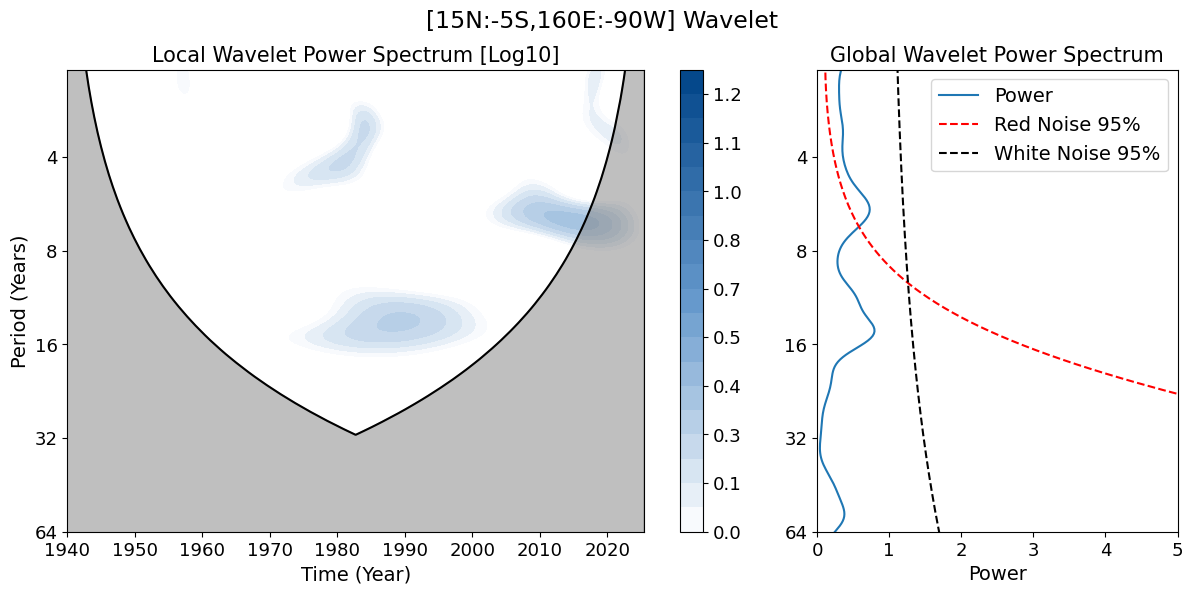

In [112]:
wavelet_log_plot(results1, 0.95,'[15N:-5S,160E:-90W] Wavelet', 20)

#### Applying it again

Red Noise AR1 Coefficient: 0.6509616457717893


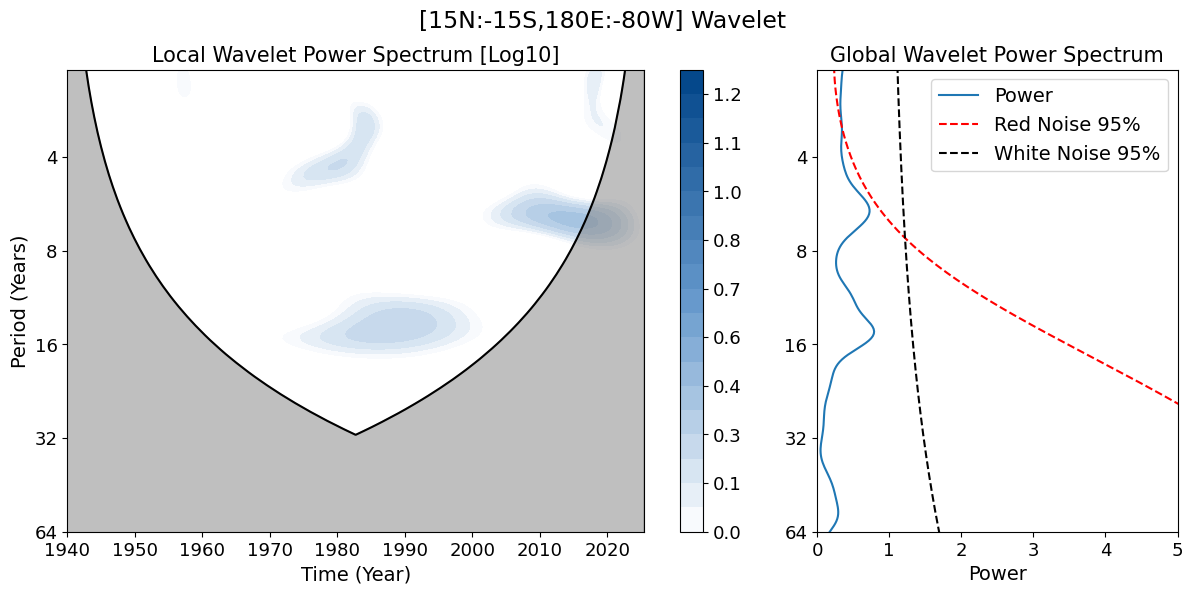

In [113]:
df2 = pd.read_csv('../signal-extraction-data/Results/sst_15N_-15S_-80W_180E-mon_sum_tp-minmax.csv')
Y2 = df2['latent'].values

wlt2 = wavelet(Y2,12)

results2 = CI_wrap(wlt2,Y2,pd.to_datetime(df2['time']).values,0.95)

wavelet_log_plot(results2, 0.95,'[15N:-15S,180E:-80W] Wavelet', 20)

Nino 3.4

Red Noise AR1 Coefficient: 0.9838685823015068


/Users/julianesler/miniconda3/envs/PANGEO/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


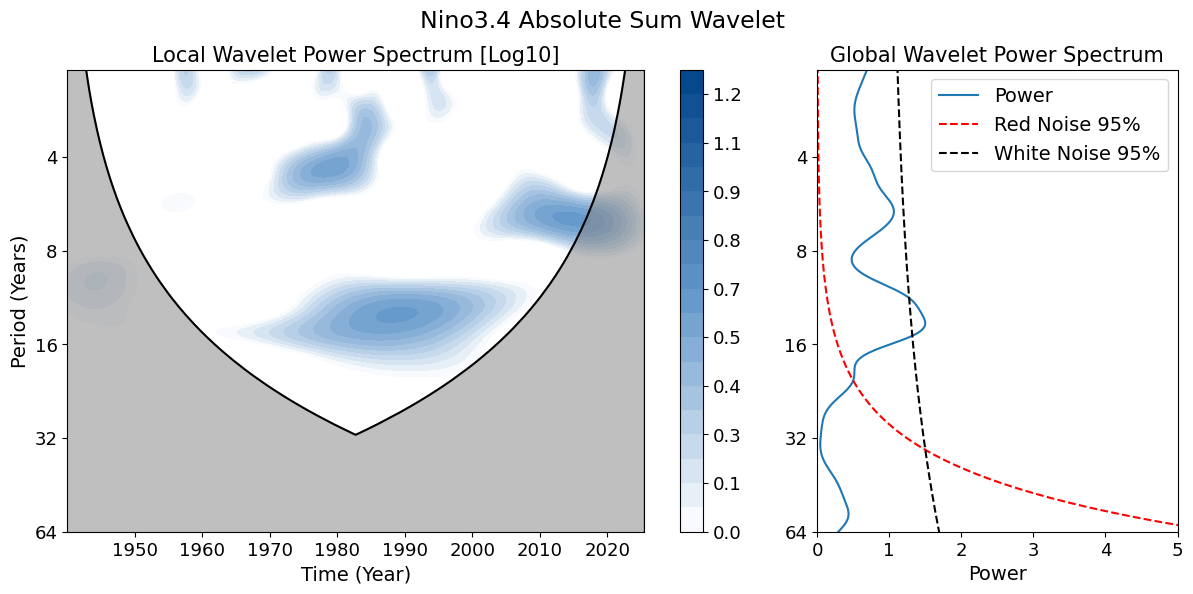

In [114]:
df3 = pd.read_csv('../signal-extraction-data/Results/mon_mean_sst-mon_sum_tp-mm.csv')
Y3 = df3['latent'].values

wlt3 = wavelet(Y3,12)

results3 = CI_wrap(wlt3,Y3,pd.to_datetime(df3['time']).values,0.95)

wavelet_log_plot(results3, 0.95,'Nino3.4 Absolute Sum Wavelet', 20)

Red Noise AR1 Coefficient: 0.9966908401452899


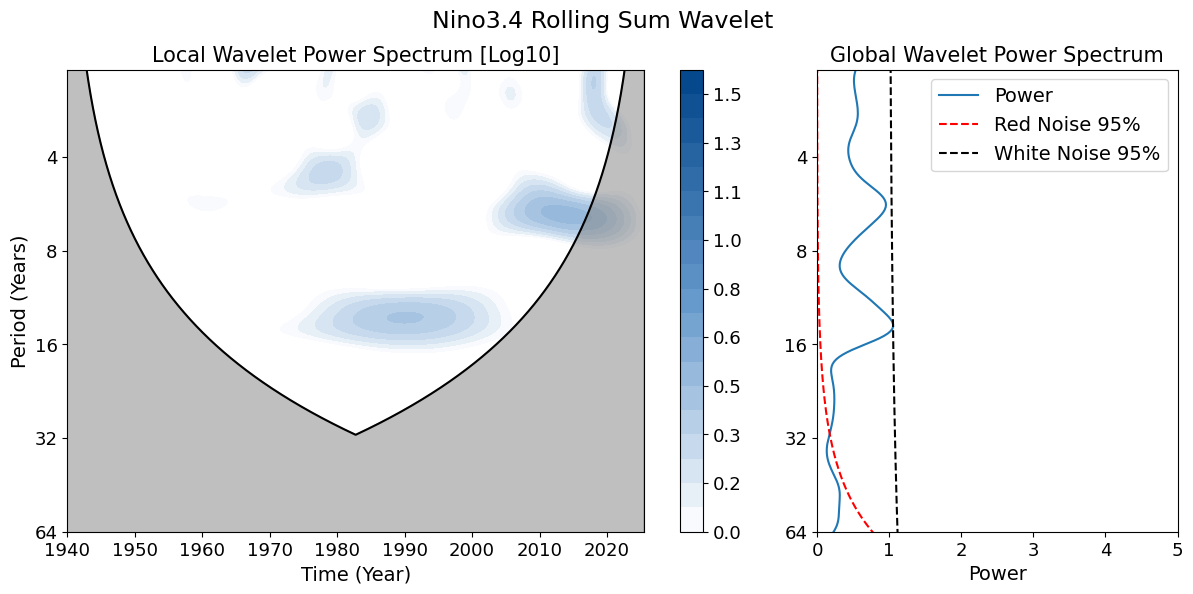

In [115]:
df4 = pd.read_csv('../signal-extraction-data/Results/roll_mean_sst-roll_sum_tp-mm.csv')
Y4 = df4['latent'].values

wlt4 = wavelet(Y4,365)

results4 = CI_wrap(wlt4,Y4,pd.to_datetime(df4['time']).values,0.95)

wavelet_log_plot(results4, 0.95,'Nino3.4 Rolling Sum Wavelet', 20)

In [43]:
# Step 1: Ensure DATE column is datetime
df4['time'] = pd.to_datetime(df4['time'])

# Step 2: Set it as the index
df4m = df4.copy().set_index('time')

# Step 3: Resample to monthly frequency and take the mean
df4m = df4m.resample('MS').mean().reset_index()  # 'MS' = Month Start

# Result: One row per month, with datetime64[ns] index
print(df4m.columns)

Index(['time', 'latent'], dtype='object')


Red Noise AR1 Coefficient: 0.8756608454451519


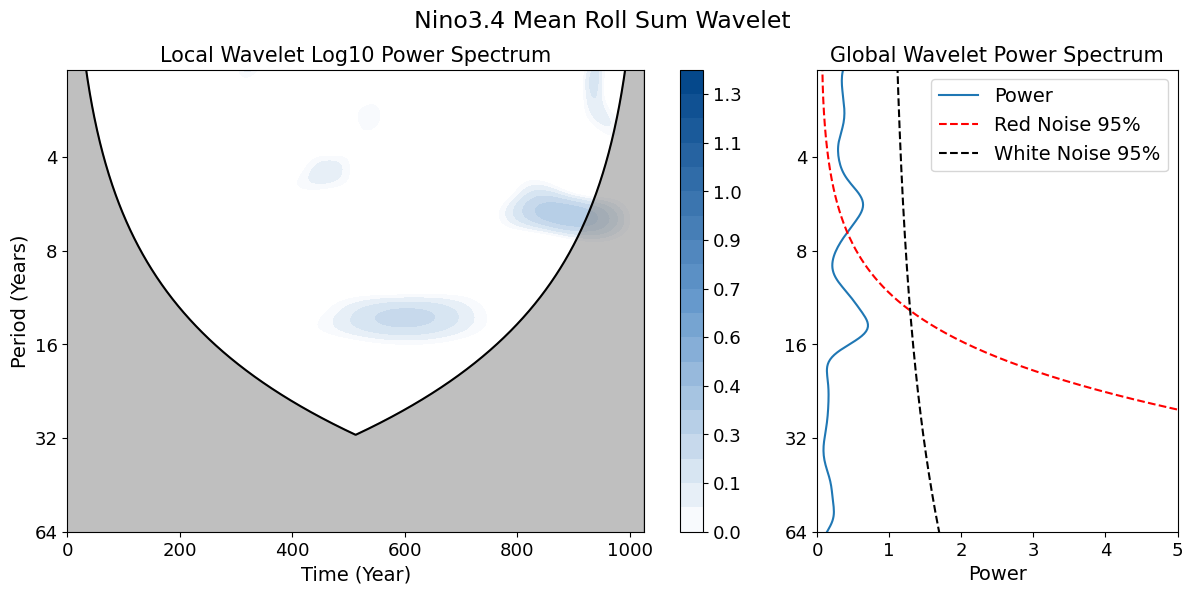

In [47]:
Y5 = df4m['latent'].values

wlt5 = wavelet(Y5,12)

results5 = CI_wrap(wlt5,Y5,0.95)

wavelet_log_plot(results5, 0.95,'Nino3.4 Mean Roll Sum Wavelet', 20)